### OBJECTIVE: Create a Content based Movie Recommendation System

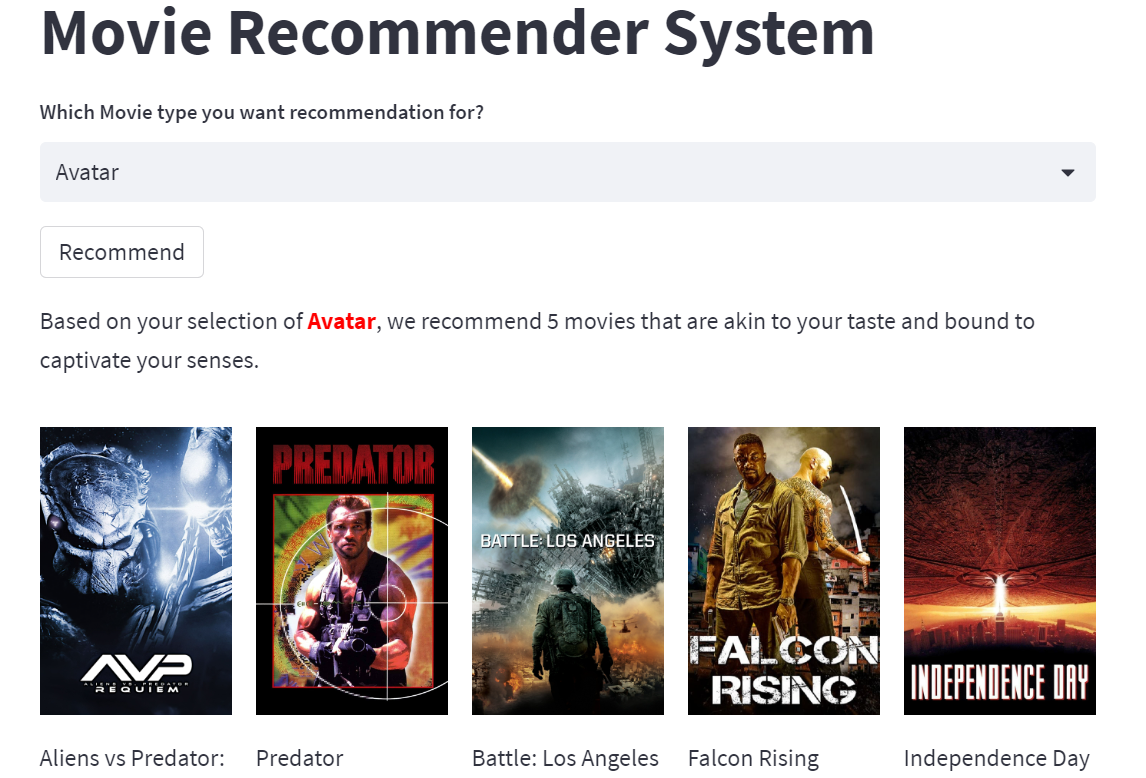

   Aim of the project is to provide personalized movie recommendations to users based on their preferences and interests. One approach to building a recommendation system is content-based filtering, which relies on analyzing the characteristics or content of movies to make recommendations (Content based recommendation system).  
    We will use TMDB (The Movie Database) website as a source of movie data and attributes. TMDB provides a comprehensive API that allows access to movie information, including metadata, cast and crew details, ratings, and posters etc. 
By utilizing this API, we will gather the necessary data to build our content-based movie recommendation system.

#### Following Analysis will be done -
1) Identifying and merging Movie details in the form of Lists into movie tags
2) Text Vectorisation : 
 - Tokenization: Breaking down the text (Movie tags) into individual words or tokens.
 - Vocabulary Construction: Creating a vocabulary of unique words.
 - Feature Encoding: Representing each document as a feature vector based on the presence or absence of words from the vocabulary. 
 - Vectorization: Organizing the feature vectors as a matrix, where each row represents a document and each column represents a word.
    In this way we will convert Movie tags into Vectors.
3) Calculate Cosine similarity between vectors
4) Create a function to identify the vectors (movies) closest (similar) to the selected movie
 

## GITHUB Repository URL
### https://github.com/rakesh82rawat?tab=repositories

## Kaggle Code URL
### https://www.kaggle.com/rakesh82rawat/code

In [ ]:
# Imports

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# From Kaggle
movies = pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv')
credits = pd.read_csv('/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv') 

In [ ]:
movies.head(2)

In [ ]:
movies.shape

In [ ]:
credits.head(2)

In [ ]:
# Merging the two datasets on 'title'(or 'movie_id)
movies = movies.merge(credits,on='title')

In [ ]:
movies.shape

In [ ]:
movies.head(2)

#> Identifying the columns to Remove that wont help in tagging-
# budget
# homepage
# id
# original_language
# original_title
# popularity
# production_comapny
# production_countries
# release-date(not sure)

In [ ]:
# movies DF with Selected columns
movies = movies[['movie_id','title','overview','genres','keywords','cast','crew']]

In [ ]:
movies.head(2)

In [ ]:
# Missing data
movies.isna().sum()[movies.isna().sum()>0]

#> Only 3 nulls in 'Overview' column, hence we will drop them directly

In [ ]:
# Drop missing Values
movies.dropna(inplace=True)

In [ ]:
movies.shape

In [ ]:
#1. First, Exploring 'genres' column for preprocessing

movies.iloc[0].genres
#> the genres are in a list of dictionaries


In [ ]:
# The genres feature is in the form of a "Sting of Lists", hence first we have to convert the sting into a list
  # Hence we use a module "ask" having a fn "literal_eval" to do this
    
import ast

In [ ]:
# Converting genres to list and extracting name from the list - 
def convert(text):
    L = []
    for i in ast.literal_eval(text):
        L.append(i['name']) 
    return L 

In [ ]:
# Converting genres col values to list using "convert" fn
movies['genres'] = movies['genres'].apply(convert)

In [ ]:
movies['genres'].head(2)
#> genres names are extracted in list format

In [ ]:
#2. Applying same procedure on keywords column -
movies['keywords'] = movies['keywords'].apply(convert)

In [ ]:
movies['keywords'].head(2)

In [ ]:
#3. From cast we need 3 top actors (name) that we will get from first 3 dictionaries of each cast entry
#import ast
#ast.literal_eval('[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]')

In [ ]:
#3. From cast we need 3 top actors (name) that we will get from first 3 dictionaries of each cast entry

def convert3(text):
    L = []
    counter = 0
    for i in ast.literal_eval(text):
        if counter < 3:
            L.append(i['name'])
        counter+=1
    return L 

In [ ]:
# Applying convert3 function to 'cast' column
movies['cast'] = movies['cast'].apply(convert)
movies.head(2)

In [ ]:
#movies['cast'] = movies['cast'].apply(lambda x:x[0:3])

In [ ]:
#4. For 'crew' column, there are mony dictionaries but we wnat the one with director name
   # we will create a function (fetch_director) to help us to fetch director
movies['crew'][0]

In [ ]:
# Function to fetch Director name

def fetch_director(text):
    L = []
    for i in ast.literal_eval(text):
        if i['job'] == 'Director':
            # The key 'job' is just a label or identifier used to access the associated value in the dictionary.
            L.append(i['name'])
    return L 

In [ ]:
movies['crew'] = movies['crew'].apply(fetch_director)

In [ ]:
movies['crew'].head(5)

In [ ]:
# DF after pre-processing -
movies.head(2)

#> But the overview column is a string - 
   # we must convert it to list format so that it can be concatenated easily with all other lists

In [ ]:
# Converting 'overview' to list
movies['overview'] = movies['overview'].apply(lambda x:x.split())
movies.sample(2)

In [ ]:
# Removing all the spaces to ensure unique entries
def collapse(L):
    L1 = []
    for i in L:
        L1.append(i.replace(" ",""))
    return L1

# OR use eg. : movies['crew'].apply(lambda x:[i.replace(" ","")for i in x])

In [ ]:
movies['cast'] = movies['cast'].apply(collapse)
movies['crew'] = movies['crew'].apply(collapse)
movies['genres'] = movies['genres'].apply(collapse)
movies['keywords'] = movies['keywords'].apply(collapse)

In [ ]:
# DF with all entries converted to Lists (except Title) and Spaces removed
movies.head(2)

In [ ]:
# Creating 'tags' column by concatenating all 5 cols in list format
movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']

In [ ]:
# new DF after dropping columns
new = movies.drop(columns=['overview','genres','keywords','cast','crew'])
#new.head()

In [ ]:
new.head(2)

In [ ]:
# Converting the 'tags' each List into String on " " - 
new['tags'] = new['tags'].apply(lambda x: " ".join(x))
new.head()

In [ ]:
# Converting all text to lower case (recommended)
# new['tags'].apply(lambda x:x.lower)

### TEXT VECTORISATION

If given a Movie, We will have to recommend similar movies based on similarities (similarity score) found in the tags of movies. For this Text vectorisation on tags column needs to be done.  
Each movie (tag) can be converted into a vector (in n dim space, n being the no. of top words considered to be analysed) and the close vectors will be similar to each other.  
  
We will use the Vectorisation technique - Bag of Words  
For this we will use Count-Vectoriser, a class in sklearn to do the word vectorisation easily
> Process: All tags are combined and high frequency words are selected against which score is given to each movie tag based on the freq. of all selected word appearing in each tag.

The Bag-of-Words (BoW) model is a way to represent text data as numerical feature vectors. It involves the following steps:

Tokenization: Breaking down the text into individual words or tokens.

Vocabulary Construction: Creating a vocabulary of unique words from the text data.

Feature Encoding: Representing each document as a feature vector based on the presence or absence of words from the vocabulary. This can be done using binary encoding, count encoding, or TF-IDF encoding.

Vectorization: Organizing the feature vectors as a matrix, where each row represents a document and each column represents a word. This matrix is called the document-term matrix.

The Bag-of-Words model ignores grammar and word order, focusing only on the occurrence of words. It simplifies the representation of text data and is used in tasks like text classification and sentiment analysis. However, it doesn't capture sequential or structural information in the text.

In [ ]:
# Importing CountVectoriser class from sklearn library
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,stop_words='english')
    

In [ ]:
vector = cv.fit_transform(new['tags']).toarray() 
# by default Count Vectoriser returns a sparse matrix (many zeros). We convert it to a np.array

In [ ]:
vector.shape

In [ ]:
vector

In [ ]:
# Upgrading sklearn library (if required)
# !pip install --upgrade scikit-learn

In [ ]:
# cv has a method - get_feature_names() that gives the list of most frequent words in the corpus
cv.get_feature_names_out()

In [ ]:
# To remove many similar and non-relevant words we use Stemming by using nltk library
# !pip install nltk

import nltk

In [ ]:
# From nltk we import a class "PorterStemmer"

from nltk.stem.porter import PorterStemmer
ps = PorterStemmer() 

In [ ]:
# Creating a helper fn "Stem" for stemming operation
def stem(text):
    y=[]
    
    for i in text.split():
        y.append(ps.stem(i))
        
    return " ".join(y)  # again converting into string

In [ ]:
new['tags']=new['tags'].apply(stem) 

In [ ]:
new['tags'][0:3] # first 3 tags

In [ ]:
# Instantiate CountVectorizer
cv = CountVectorizer()

In [ ]:
# repeating Vectorisation & fetching feature names(can be done above also by overwriting)
vector = cv.fit_transform(new['tags']).toarray()

In [ ]:
# Get the feature names
feature_names = cv.get_feature_names_out()

# Print the feature names
print(feature_names)


In [ ]:
cv.get_feature_names_out()

#> ~Repeated words are removed

In [ ]:
vector.shape # There are 4806 movies hence 4806 vectors in 5000 dim.space

**MEASURING SIMILARITY BETWEEN TWO VECTORS**

**COSINE SIMILARITY** : Cosine similarity is a measure used to determine the similarity between two vectors by calculating the cosine of the angle between them. It is commonly used in text analysis and recommendation systems. The similarity score ranges from -1 to 1, where 1 represents identical vectors, 0 represents no similarity, and -1 represents completely opposite vectors. Cosine similarity is scale-invariant, direction-invariant, and computationally efficient. It is widely applied in tasks such as document similarity, text classification, and clustering.

In [ ]:
# Finding Cosine distance (Angle) between vectors
# bcs in higher dims, eucledian distance is not reliable
# For this we use a fn in sklearn - cosine_similarity

from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# Finding cosine similarity for all vectors
similarity = cosine_similarity(vector)

In [ ]:
similarity.shape # similarity of each movie with 4806 movies

In [ ]:
display(similarity) # Its an Array of Arrays


In [ ]:
# To get index no. of a selected movie eg.-
new[new['title'] == 'The Lego Movie'].index[0]

In [ ]:
# Creating a fn that will give 5 similar movies for any given movie

def recommend(movie):
    index = new[new['title'] == movie].index[0]
    # We use enumerate so that the index position stays intact (tuple) after sorting also
    # sorting to be done on 2nd col (cosine similarity) not on index hence lambda fn used
    movies_list = sorted(list(enumerate(similarity[index])),reverse=True,key = lambda x: x[1])
    
    # We need 1st to 5th item from the sorted list
    for i in movies_list[1:6]:
    # Fetching movie names from index   
        print(new.iloc[i[0]].title)
        
    

In [ ]:
# example
recommend('Avatar')

## Website building

In [ ]:
import pickle

In [ ]:
pickle.dump(new,open('movie_list.pkl','wb'))  # pickle file of DF 'new'

pickle.dump(similarity,open('similarity.pkl','wb'))

In [ ]:
# Converting 'new' DF to dictionary format as the pickle file of DF is not acceptable in streamlit

new.to_dict()

In [ ]:
pickle.dump(new,open('movie_dict.pkl','wb'))

CONCLUSION:  
The Movie Recommender model built using the content-based recommendation approach offers a personalized movie recommendation system based on the content and characteristics of movies. By analyzing movie metadata such as genres, actors, directors, and plot keywords, the model identifies similarities between movies and suggests relevant recommendations.

The model leverages the CountVectorizer from the scikit-learn library to convert textual movie attributes into numerical representations. These representations are then used to calculate the cosine similarity between movies, determining their similarity based on shared features.

To enhance user experience and accessibility, the movie recommender model is deployed on the web using Streamlit, a user-friendly framework for building data-driven applications. Streamlit allows users to interact with the model, select movies, and receive personalized recommendations. The web interface provides an intuitive and engaging platform for users to discover new movies based on their preferences.

The Kaggle and Github link to all project files are given for reference in the start.

**Thank You for your unparalleled love and support :)**